In [1]:
from model import FFNet, tv_model, ResBam
from learning import Learn, Selector, Metrics
import dataset
from dataset import SKDS, TVDS, CDataset

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms


In [ ]:
import numpy as np

class Dummy(CDataset):
    
    def load_data(self, boom='bust'):
        data = {1: (np.asarray([1,2,3,4]), np.asarray(100), ['apple','dog']),
                2: (np.asarray([5,6,7,8]), np.asarray(200), ['orange','cat'])}
        print(boom)
        return data
    
ds_params = {'train_params': {'embed': [('fruit',2,8,False,False),
                                        ('pet',2,8,False,False)],
                              'embed_lookup': {'fruit': {'apple': 1,
                                                         'orange': 2},
                                               'pet': {'dog': 1,
                                                       'cat': 2}},
             'boom': 'bang'}}
    
d = Dummy(**ds_params['train_params'])
d[1]           

In [ ]:
ds_params={'embed': [],
           'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = dataset.ImageDatasetStats()

for i in tvds.ds_idx:
    ids(tvds[i][0])
    
print(ids.stats.mean) #33.3
print(ids.stats.stddev) #73.7

In [ ]:
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'embed': [],
                              'make': 'make_regression',
                              'transform': None,
                              'target_transform': None,
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=20)

In [ ]:
test loss: 10946.8962890625

In [ ]:
model_params = {'D_in': 256, 
                'H': 192, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'embed': [],
                              'make': 'make_classification',
                              'transform': transforms.Compose([dataset.AsTensor()]),
                              'target_transform': transforms.Compose(
                                                      [dataset.DType('int64'),
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()]),
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 256,
                                            'n_informative': 50,
                                            'n_clusters_per_class': 10,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

In [ ]:
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'embed': [],
                            'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(224),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'embed': [],
                           'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(224),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=16, epochs=4)

In [ ]:
test loss: 1.798008106803894
learning time: 0:00:58.230340
test sklean metric: 
0.8089919555555556 

TVDS created...
TVDS created...
CModel loaded...
ResBam model loaded...
learning time: 0:00:17.751886
epoch: 0, lr: 0.005
train loss: 1.9229778455149742, val loss: 1.8236725727717082
sk_train_log: 0.7633903873815495, sk_val_log: 0.7971520531332269
learning time: 0:00:35.142746
epoch: 1, lr: 0.005
train loss: 1.7476422959758389, val loss: 1.6746777455012003
sk_train_log: 0.8148040399636383, sk_val_log: 0.833686499453227
learning time: 0:00:52.540224
epoch: 2, lr: 0.005
train loss: 1.634048948364873, val loss: 1.614292041460673
sk_train_log: 0.8427390337891334, sk_val_log: 0.8413951592232867
learning time: 0:01:10.051881
epoch: 3, lr: 0.005
train loss: 1.5421717243809854, val loss: 1.5259878953297934
sk_train_log: 0.8597960987390609, sk_val_log: 0.8599068321716057
learning time: 0:01:27.525166
epoch: 4, lr: 0.005
train loss: 1.481439875018212, val loss: 1.51892778078715
sk_train_log: 0.8713908419934683, sk_val_log: 0.8627823600179347
learning time: 0:01:45.160816
epoch: 5, lr: 0.005
trai

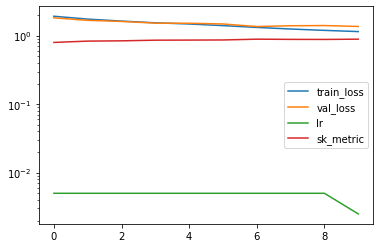

In [4]:
model_params = {'n_classes': 10,
                'residuals': False,
                'in_channels': 3,
                'groups': 1,
                'bam': False,
                'dropout': [False,False,False,False,False],
                'pool': False,
                'act': None}


ds_params={'train_params': {'embed': [],
                            'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'embed': [],
                           'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.005}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          ResBam, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=64, epochs=10)

In [ ]:
epoch: 9, lr: 0.005
train loss: 1.1656932869265157, val loss: 1.3973329226175943
sk_train_log: 0.9222684937295241, sk_val_log: 0.8825878255522271
test loss: 1.3942259443111908
learning time: 0:03:15.848135
test sklean metric: 
0.8838260697026292 

In [ ]:
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'embed': [],
                            'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'embed': [],
                           'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=32, epochs=10)